# Run the `snowBMI` model using Basic Model Interface commands

This notebook demonstrates the execution of a simple temperature index snow model using BMI. View the source code for the [model](https://github.com/SnowHydrology/snowBMI/blob/master/snow/snow.py) and its [BMI](https://github.com/SnowHydrology/snowBMI/blob/master/snow/bmi_snow.py) on GitHub.

This exercise is based on the [heat](https://github.com/csdms/bmi-example-python) example from [CSDMS](https://csdms.colorado.edu/wiki/Main_Page).

Start by importing `os`, `numpy` and the `Snow` BMI:

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from snow import SnowBmi

Create an instance of the model's BMI.

In [2]:
x = SnowBmi()

Use the BMI `get_component_name` function to query the model's name.

In [3]:
print(x.get_component_name())

Temperature Index Snow Model with BMI


Start the `Snow` model through its BMI using a configuration file. First, take a look at the file and then run the BMI `initialize` function.

In [4]:
cat snow.yaml

# Snow model configuration
rs_method: 1         # 1 = single threshold, 2 = dual threshold
rs_thresh: 2.5       # rain-snow temperature threshold when rs_method = 1 (°C)
snow_thresh_max: 1.5 # maximum all-snow temp when rs_method = 2 (°C)
rain_thresh_min: 4.5 # minimum all-rain temp when rs_method = 2 (°C)
ddf_max: 1           # maximum degree day melt factor (mm/day/°C)
ddf_min: 0           # minimum degree day melt factor (mm/day/°C)
tair_melt_thresh: 1  # air temperature threshold above which melt can occur (°C)
swe_init: 0          # initial snow water equivalent (mm)
dayofyear: 274       # Day of year of simulation start (ex: 1 = Jan 1, 274 = Oct 1)
year: 2020           # year of simulation start

In [5]:
x.initialize("snow.yaml")

Check the time information for the model.

In [6]:
print("Start time:", x.get_start_time())
print("End time:", x.get_end_time())
print("Current time:", x.get_current_time())
print("Time step:", x.get_time_step())
print("Time units:", x.get_time_units())

Start time: 0.0
End time: 1.7976931348623157e+308
Current time: 0.0
Time step: 86400
Time units: s


Show the input and output variables for the component (aside on [Standard Names](https://csdms.colorado.edu/wiki/CSDMS_Standard_Names)):

In [7]:
print("Input vars =", x.get_input_var_names())
print("Output vars =", x.get_output_var_names())

Input vars = ('atmosphere_water__precipitation_leq-volume_flux', 'land_surface_air__temperature')
Output vars = ('snowpack__liquid-equivalent_depth', 'snowpack__melt_volume_flux')


For a quick example, set air temperature and precipitation to a constant value using standard BMI functions.

In [8]:
# when the model is initialized, air temperature equals 0
# we can check this using either get_value or get_value_ptr
temp_array = np.zeros(1,)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value =", temp_array)
print("Air temperature from get_value_ptr =", x.get_value_ptr('land_surface_air__temperature'))

# Now we can set the value of air temperature
# first make a numpy single-element array and give it a value
air_temperature = np.full(1, -5)

# Then set the value and check it with get_value
x.set_value("land_surface_air__temperature", air_temperature)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value after set_value=", temp_array)
print("Air temperature from get_value_ptr after set_value=", x.get_value_ptr('land_surface_air__temperature'))

# And let's do the same for precipitation
precip = np.full(1, 10)
print("Precipitation from get_value_ptr =", x.get_value_ptr("atmosphere_water__precipitation_leq-volume_flux"))
x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
print("Precipitation from get_value_ptr after set_value=", x.get_value_ptr('atmosphere_water__precipitation_leq-volume_flux'))

Air temperature from get_value = [0.]
Air temperature from get_value_ptr = [0.]
Air temperature from get_value after set_value= [-5.]
Air temperature from get_value_ptr after set_value= [-5.]
Precipitation from get_value_ptr = [0.]
Precipitation from get_value_ptr after set_value= [10.]


A key advantage of BMI is that **we don't have to know the names of any of the input or output variables**. We can query the model and have standardized BMI functions return their names and values (and even their units!). This means no more spending hours poring over code to get the simplest info—you can use the same functions over and over again to get the info you require.

In [15]:
# we can also look at all values with a loop
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))
output_vars = x.get_output_var_names()
for tmp in output_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))

atmosphere_water__precipitation_leq-volume_flux = [10.] mm h-1
land_surface_air__temperature = [15.] C
snowpack__liquid-equivalent_depth = [938.5597238] mm
snowpack__melt_volume_flux = [3.13286144] mm h-1


In [10]:
# update for a set number of time steps
run_steps = 100
for i in range(run_steps):
    x.update()
    print("swe =", x.get_value_ptr("snowpack__liquid-equivalent_depth"))
    print("doy =", x._model._dayofyear)

swe = [10.]
doy = 275
swe = [20.]
doy = 276
swe = [30.]
doy = 277
swe = [40.]
doy = 278
swe = [50.]
doy = 279
swe = [60.]
doy = 280
swe = [70.]
doy = 281
swe = [80.]
doy = 282
swe = [90.]
doy = 283
swe = [100.]
doy = 284
swe = [110.]
doy = 285
swe = [120.]
doy = 286
swe = [130.]
doy = 287
swe = [140.]
doy = 288
swe = [150.]
doy = 289
swe = [160.]
doy = 290
swe = [170.]
doy = 291
swe = [180.]
doy = 292
swe = [190.]
doy = 293
swe = [200.]
doy = 294
swe = [210.]
doy = 295
swe = [220.]
doy = 296
swe = [230.]
doy = 297
swe = [240.]
doy = 298
swe = [250.]
doy = 299
swe = [260.]
doy = 300
swe = [270.]
doy = 301
swe = [280.]
doy = 302
swe = [290.]
doy = 303
swe = [300.]
doy = 304
swe = [310.]
doy = 305
swe = [320.]
doy = 306
swe = [330.]
doy = 307
swe = [340.]
doy = 308
swe = [350.]
doy = 309
swe = [360.]
doy = 310
swe = [370.]
doy = 311
swe = [380.]
doy = 312
swe = [390.]
doy = 313
swe = [400.]
doy = 314
swe = [410.]
doy = 315
swe = [420.]
doy = 316
swe = [430.]
doy = 317
swe = [440.]
doy = 3

In [12]:
# Try updating air temp to produce melt
air_temperature = np.full(1, 15)

# Then set the value and check it with get_value
x.set_value("land_surface_air__temperature", air_temperature)
print("Air temperature from get_value_ptr after set_value=", x.get_value_ptr('land_surface_air__temperature'))

# update for a set number of time steps
run_steps = 20
for i in range(run_steps):
    x.update()
    print("swe =", x.get_value_ptr("snowpack__liquid-equivalent_depth"))
    print("melt =", x.get_value_ptr("snowpack__melt_volume_flux"))


Air temperature from get_value_ptr after set_value= [15.]
swe = [982.25499326]
melt = [1.46327585]
swe = [980.71716906]
melt = [1.53782419]
swe = [979.10317788]
melt = [1.61399119]
swe = [977.41142362]
melt = [1.69175426]
swe = [975.64033327]
melt = [1.77109036]
swe = [973.78835729]
melt = [1.85197598]
swe = [971.85397014]
melt = [1.93438715]
swe = [969.83567068]
melt = [2.01829946]
swe = [967.73198265]
melt = [2.10368803]
swe = [965.5414551]
melt = [2.19052756]
swe = [963.26266278]
melt = [2.27879231]
swe = [960.89420664]
melt = [2.36845614]
swe = [958.43471418]
melt = [2.45949247]
swe = [955.88283986]
melt = [2.55187432]
swe = [953.23726555]
melt = [2.64557431]
swe = [950.49670086]
melt = [2.74056469]
swe = [947.65988357]
melt = [2.83681729]
swe = [944.72557997]
melt = [2.9343036]
swe = [941.69258523]
melt = [3.03299473]
swe = [938.5597238]
melt = [3.13286144]


Although it's fun to look at printed data and manually control the loops, let's try running an example simulation now using real forcing data from a SNOTEL station. First, we'll reinitialize the model and then import the data.

In [27]:
# Reinitialize the model
x.initialize("snow.yaml")

# Import the example SNOTEL data
forcing = pd.read_csv("data/snotel_663_data.csv")
print(forcing.head(10))

         date  swe_mm  tair_c  ppt_mm
0  2012-10-01     0.0     5.4     0.0
1  2012-10-02     0.0    10.6     0.0
2  2012-10-03     0.0     7.5     0.0
3  2012-10-04     0.0    -1.1     0.0
4  2012-10-05     0.0    -1.3     0.0
5  2012-10-06     0.0    -5.6     0.0
6  2012-10-07     0.0    -0.5     2.5
7  2012-10-08     0.0     5.2     0.0
8  2012-10-09     0.0     3.9     0.0
9  2012-10-10     0.0     6.8     0.0


We can see in the dataframe above that we have everything we need to run `snowBMI`, specifically air temperature and precipitation.

Now we can run a `snowBMI` update loop based on the number of entries in the forcing data. Importantly, we'll use BMI::set_value to apply the forcing data to the model and BMI::get_value to access model data for plotting and analysis.

In [28]:
# Make an empty array to store the output data
swe_output = np.zeros(forcing.date.size)

# Loop through the data and run snowBMI
for i in range(forcing.date.size):
    air_temperature = np.full(1, forcing.tair_c[i])
    precip = np.full(1, forcing.ppt_mm[i])
    x.set_value("land_surface_air__temperature", air_temperature)
    x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
    x.update()
    swe_output[i] = x.get_value_ptr("snowpack__liquid-equivalent_depth")

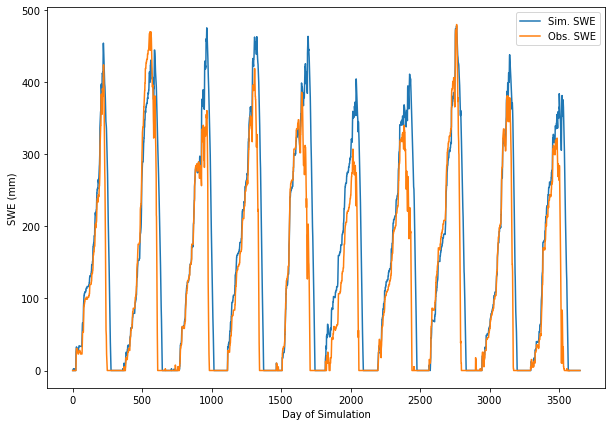

In [34]:
# Plot the simulated swe
plt.figure(figsize=(10, 7))
#plt.plot(sample_data['qobs_CAMELS_mm_per_hour'][ibasin][start_plot:end_plot], label='obs', c='k')
plt.plot(swe_output,label='Sim. SWE')
plt.plot(forcing.swe_mm, label='Obs. SWE')
#plt.plot(nh_hourly_slope_mean_precip_temp_01022500[t2000+start_plot:t2000+end_plot],label='LSTM NH')
#plt.ylim([0,0.5])
plt.ylabel('SWE (mm)')
plt.xlabel('Day of Simulation')
plt.legend()
plt.show()
plt.close()

In [13]:
print(x._values)
print(x._model._dayofyear)
print(x._model._year)
print(x._model._tair_c)
test = x.get_value_ptr("snowpack__melt_volume_flux")
print(test)
print(test.shape)

{'atmosphere_water__precipitation_leq-volume_flux': array([10.]), 'land_surface_air__temperature': array([15.]), 'snowpack__liquid-equivalent_depth': array([938.5597238]), 'snowpack__melt_volume_flux': array([3.13286144])}
48
2021
[15.]
[3.13286144]
(1,)


Next, get the identifier for the grid on which the temperature variable is defined:

In [ ]:
grid_id = x.get_var_grid("plate_surface__temperature")
print("Grid id:", grid_id)

Then get the grid attributes:

In [ ]:
print("Grid type:", x.get_grid_type(grid_id))

rank = x.get_grid_rank(grid_id)
print("Grid rank:", rank)

shape = np.ndarray(rank, dtype=int)
x.get_grid_shape(grid_id, shape)
print("Grid shape:", shape)

spacing = np.ndarray(rank, dtype=float)
x.get_grid_spacing(grid_id, spacing)
print("Grid spacing:", spacing)

These commands are made somewhat un-Pythonic by the generic design of the BMI.

Through the model's BMI, zero out the initial temperature field, except for an impulse near the middle.
Note that *set_value* expects a one-dimensional array for input.

In [ ]:
temperature = np.zeros(shape)
temperature[3, 4] = 100.0
x.set_value("plate_surface__temperature", temperature)

Check that the temperature field has been updated. Note that *get_value* expects a one-dimensional array to receive output.

In [12]:
temperature_flat = np.empty_like(temperature).flatten()
x.get_value("plate_surface__temperature", temperature_flat)
print(temperature_flat.reshape(shape))

AttributeError: 'int' object has no attribute 'flatten'

Now advance the model by a single time step:

In [ ]:
x.update()

View the new state of the temperature field:

In [ ]:
x.get_value("plate_surface__temperature", temperature_flat)
print(temperature_flat.reshape(shape))

There's diffusion!

Advance the model to some distant time:

In [ ]:
distant_time = 2.0
while x.get_current_time() < distant_time:
    x.update()

View the final state of the temperature field:

In [ ]:
np.set_printoptions(formatter={"float": "{: 5.1f}".format})
x.get_value("plate_surface__temperature", temperature_flat)
print(temperature_flat.reshape(shape))

Note that temperature isn't conserved on the plate:

In [ ]:
print(temperature_flat.sum())

End the model:

In [ ]:
x.finalize()